## Открытие  файлов  с данными и изучение общей информации

# Определение перспективного тарифа для телеком-компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов**

**Тариф смарт**  
Ежемесячная плата: 550 рублей  
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика  
Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.

**Тариф Ультра**   
Ежемесячная плата: 1950 рублей  
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика  
Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.


*«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.*

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st 
import math 
import seaborn as sns

pd.set_option('display.max_columns', 35)
pd.set_option('display.max_rows', 70)
pd.set_option('display.float_format', '{:,.2f}'.format)

In [2]:
df = pd.read_csv('/datasets/users.csv')  # Информация о пользователях 
df_calls = pd.read_csv('/datasets/calls.csv')  # Информация о звонках 
df_messages = pd.read_csv('/datasets/messages.csv') # Информация о сообщениях
df_internet = pd.read_csv('/datasets/internet.csv') # Информация об интернет сессиях 
df_tariffs = pd.read_csv('/datasets/tariffs.csv') # Информация о тарифах 

### df

Начинаю изучения с датасета df (он будет основным именно к нему буду присоединять далее другие таблицы). Для этого выведу инфо по таблице и так же посмотрю значения в таблице

In [3]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [4]:
df[df['churn_date'].notna()].head()  #смотрю таблицу данным методом из-за того, что church_date имеет пропуски 

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
19,1019,63,2018-10-05,Томск,Игнатий,Круглов,2018-05-16,ultra
20,1020,59,2018-12-18,Чита,Тала,Костина,2018-10-22,smart
34,1034,66,2018-11-21,Вологда,Святослав,Бондарев,2018-08-26,smart
50,1050,44,2018-10-03,Тюмень,Рузана,Аничкина,2018-06-16,ultra
51,1051,37,2018-10-14,Москва,Кристина,Сомова,2018-05-28,smart


In [5]:
df['tariff'].value_counts() #проверяю не затесались в тарифе лишние данные. Метод должен выдать два значения

smart    351
ultra    149
Name: tariff, dtype: int64

In [6]:
df['user_id'].duplicated().sum() #id пользователей не должны повторяться 

0

In [7]:
df['churn_date'] = pd.to_datetime(df['churn_date'], format = '%Y-%m-%d')
df['reg_date'] = pd.to_datetime(df['reg_date'], format = '%Y-%m-%d')

In [8]:
df.dtypes  # проверяю как изменились данные 

user_id                int64
age                    int64
churn_date    datetime64[ns]
city                  object
first_name            object
last_name             object
reg_date      datetime64[ns]
tariff                object
dtype: object

**Вывод**  
В таблице аномалий не выявленно. Пропуски в churn_date вызваны тем, что тариф не был отменён на момент выгрузки данных.


### df_calls
перехожу к изучению датасета с информацией о звонках 

In [9]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [10]:
df_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [11]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format = '%Y-%m-%d')  # изменяю тип данных 

In [12]:
df_calls.dtypes # проверяю как изменился тип данных

id                   object
call_date    datetime64[ns]
duration            float64
user_id               int64
dtype: object

In [13]:
round(1-(len(df_calls['user_id'].unique())/500), 3) # узнаю долю пользователей не совершавших звонки 

0.016

In [14]:
df_calls['duration'].value_counts().to_frame() # просматриваю какая длительность звонков была произведена

,duration
0.00,39613
5.50,142
4.49,142
6.15,141
6.38,141
...,...
26.32,1
24.51,1
27.24,1
29.89,1


Обнаруженны звонки с длительностью 0.00. Это те звонки на которые не взяли трубку.   
на 39613 звонков не взяли трубку

**Вывод**   
Пропусков в данном датасете нет. Так же наблюдаем, что 1.6% пользователей(из заданной выборки) в установленный временой переод не звонили.  
Так же на 39613 вызовов не взяли трубку. Почти  каждый 5ый звонок остался без ответа

### df_messages 

переходим к датафайлу с информацией о сообщениях 

In [15]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [16]:
df_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [17]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format = '%Y-%m-%d') # изменяю тип данных

In [18]:
round(1-(len(df_messages['user_id'].unique())/500),3) # вывожу долю пользователей не отправлющих смс

0.148

**Вывод**   
Почти 15% пользователей за заданное время ни разу не отправляли сообщения

### df_internet 


In [19]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [20]:
df_internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,"1,052.81",2018-09-07,1000
2,2,1000_2,"1,197.26",2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Наблюдаем странные столбец, которого нет в документации. Посмотрим какие он выдаёт значения в конце 

In [21]:
df_internet.tail()

,Unnamed: 0,id,mb_used,session_date,user_id
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,"1,246.32",2018-11-26,1499
149395,149395,1499_156,544.37,2018-10-26,1499


Делаем предполжожение, что это небольшая ошибка и  Unnamed:0 просто дублирует номер строки. На всякий случай перепроверю это 

In [22]:
len(df_internet['Unnamed: 0'].unique())

149396

Да, этот столбец содержит в себе номер строк и идёт от 0 до 149395.  Информации для нас он никакой не несёт, потому можем избавиться от него 

In [23]:
df_internet.drop('Unnamed: 0', axis = 1, inplace = True) # удаляем лишний столбец.
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format = '%Y-%m-%d')
# так же изменяю тип данных столбца session_date

In [24]:
df_internet.dtypes #проверяю как сработали методы 

id                      object
mb_used                float64
session_date    datetime64[ns]
user_id                  int64
dtype: object

In [25]:
round(1-(len(df_internet['user_id'].unique())/500),3) #Доля пользователей  не использующие интернет

0.006

**Вывод**  
Пользователи активнее всего пользуются интернетом. Меньше процента пользователей из заданной выборки не пользовались интернетом 

### df_tariffs

In [26]:
df_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


В таблице количество интренет трафика дано в мб. Исправляю на доступный интернет трафик в гигабайтах

In [27]:
df_tariffs['mb_per_month_included'] = df_tariffs['mb_per_month_included'].apply(lambda x: int(np.ceil(x/1024)))
df_tariffs.rename(columns = {'mb_per_month_included':'gb_per_month_included'}, inplace = True)

In [28]:
df_tariffs.head()

,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15,500,550,200,3,3,smart
1,1000,30,3000,1950,150,1,1,ultra


### Вывод  
Данные датасеты заполнены хорошо. Критичные пропуски не выявлены. Так же беглый осмотр данных показывает, что менее 1% пользователей из данной выборки не пользовались интернетом.
Хуже всего обстоят дела с отправкой смс. Почти 15% пользователей не использовали смс для отправки сообщений. Возможно в век развития интернета и при наличие мессенджеров отправка смс теряет свою актуальность

## Подготовка данных 

### df_calls

Начну с таблицы с иформацией о звонках.  
Из-за особенностей оператора, даже разговор с длительностью 1 секунда окргуляется до 1 минуты.   
Поэтому надо всю информацию о звонках округлить в большую сторону

In [29]:
df_calls['duration'] = df_calls['duration'].apply(np.ceil) # округляю длительность звонков до целых чисел в большую сторону
df_calls['month'] = pd.DatetimeIndex(df_calls['call_date']).month #создаю столбец со значением месяца

Далее я создаю таблицу df_calls_final  с длительностью и количеством звонков по месяцам

In [30]:
df_calls_final = df_calls.groupby(['user_id', 'month'])['duration'].agg(['sum', 'count']).reset_index()
df_calls_final.rename(columns = {'sum':'duration_of_calls', 'count': 'number_of_calls'}, inplace = True)

In [31]:
df_calls_final.head()

,user_id,month,duration_of_calls,number_of_calls
0,1000,5,159.00,22
1,1000,6,172.00,43
2,1000,7,340.00,47
3,1000,8,408.00,52
4,1000,9,466.00,58


### df_message 

In [32]:
df_messages['month'] = pd.DatetimeIndex(df_messages['message_date']).month # создаю столбец с названием месяца

Далее я создаю таблицу df_messages_count, в которой будут указано количество отправленных в месяц сообщений для каждого пользователя. И проделываю хорошо знакомый нам алгоритм группировки таблицы 

In [33]:
df_messages_count = df_messages.groupby(['user_id', 'month'])['id'].count().reset_index() 
df_messages_count.rename(columns  = {'id': 'number_of_messages'}, inplace = True)
df_messages_count.head()

,user_id,month,number_of_messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


### df_internet

Перехожу к датафайлу с интернет трафиком 

In [34]:
df_internet['month'] = pd.DatetimeIndex(df_internet['session_date']).month # создаю столбец с названием месяца

In [35]:
df_internet_spent = df_internet.groupby(['user_id', 'month'])['mb_used'].sum().reset_index()
df_internet_spent.head()

,user_id,month,mb_used
0,1000,5,"2,253.49"
1,1000,6,"23,233.77"
2,1000,7,"14,003.64"
3,1000,8,"14,055.93"
4,1000,9,"14,568.91"


По условиям пользования оператор снимает деньги за гигабайты. Причём всегда число округляется в большую сторону

In [36]:
def gigabyte(values):
    '''функция переводит мб в гигабайты'''
    return int(np.ceil(values/1024))

In [37]:
df_internet_spent['mb_used'] = df_internet_spent['mb_used'].apply(gigabyte) # применяю функцию к сталбцу 
df_internet_spent.rename(columns = {'mb_used':'gb_used'}, inplace = True) #меняю название столбца 
df_internet_spent.head()

,user_id,month,gb_used
0,1000,5,3
1,1000,6,23
2,1000,7,14
3,1000,8,14
4,1000,9,15


### Вывод 

Все датасеты готовы к объединению. И так же помня особенности обслуживания пользователей, в нужных местах округлил значения и перевёл мб в гигабайты. 

## объединение данных в одну таблицу

In [38]:
data = df_internet_spent.merge(df_calls_final, on = ['user_id', 'month'], how = 'outer')
#объединяю 2 датасета с информацией о звонках и используемом интеренете

Я применяю how = 'outer' из-за того, что другие методы объединения лишают нас части важных данных. Чего я хотел бы избежать всеми возможными способами 

Далее присоединяю все оставшиеся датасеты

In [39]:
df = df.merge(data, on = 'user_id', how = 'outer')
df = df.merge(df_messages_count, on = ['user_id', 'month'],  how = 'outer')
df.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,gb_used,duration_of_calls,number_of_calls,number_of_messages
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.00,3.00,159.00,22.00,22.00
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.00,23.00,172.00,43.00,60.00
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.00,14.00,340.00,47.00,75.00
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.00,14.00,408.00,52.00,81.00
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.00,15.00,466.00,58.00,57.00


In [40]:
df.shape # вывожу размеры таблицы

(3216, 13)

Что бы удостовериться, что таблицы "нормально" соединились, выведу так же значения с конца

In [41]:
df.tail()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,gb_used,duration_of_calls,number_of_calls,number_of_messages
3211,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,10.00,21.00,247.00,41.00,42.00
3212,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,9.00,2.00,70.00,9.00,11.00
3213,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,10.00,18.00,449.00,68.00,48.00
3214,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,11.00,18.00,612.00,74.00,59.00
3215,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,12.00,13.00,492.00,69.00,66.00


В некотрых месяцах люди могли не пользоваться некоторыми видами связи(интернетом/звонками/смс сообщениями). Предлагаю проверить эту гипотезу. Если она подтвердится, то пропуски заполним нулями 

In [42]:
df.isna().sum().to_frame()

,0
user_id,0
age,0
churn_date,3027
city,0
first_name,0
last_name,0
reg_date,0
tariff,0
month,2
gb_used,13


In [43]:
value = ['gb_used', 'duration_of_calls', 'number_of_calls', 'number_of_messages']
df[value] = df[value].fillna(0)

Наблюдаем, что появилось 2 пропуска в месяцах, надо посмотреть данные значения, что бы понять чем это вызвано 

In [44]:
df[df['month'].isna()]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,gb_used,duration_of_calls,number_of_calls,number_of_messages
827,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,NaN,0.00,0.00,0.00,0.00
2335,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,NaN,0.00,0.00,0.00,0.00


Пользователи подключали тариф менее чем на месяц,и не пользовали интернетом/смс сообщениями/звонками
И всё это произошло в 12 месяце

In [45]:
df['month'] = df['month'].fillna(12)

Так же надо сделать проверку не потерялись ли какие нибудь данные. В начале проверю не потерялась ли информация о звонках и интернет трафике 

In [46]:
df_calls['duration'].sum() == df['duration_of_calls'].sum()

True

In [47]:
df_internet_spent['gb_used'].sum() == df['gb_used'].sum()

True

In [48]:
df['user_id'].nunique()

500

**Вывод**

Объединение таблиц прошло успешно. Пропуски заполнены 

### Добавление стоимости месячного обслуживания

Для получившейся таблицы, надо добавить столбец с месячной выручкой. Нам предоставили методику расчёта, осталось написать функцию 

In [49]:
def cost_finaly(df):
    '''функция расчитывает месячную выручку за обслуживание клиента'''
    if df['tariff'] == df_tariffs.iloc[1][-1]:
        i = df_tariffs.iloc[1][3] 
        if df['duration_of_calls'] > df_tariffs.iloc[1][2]:
            i += (df['duration_of_calls'] - df_tariffs.iloc[1][2]) * df_tariffs.iloc[1][-2]
        if df['number_of_messages'] >df_tariffs.iloc[1][0]:
            i += (df['number_of_messages'] - df_tariffs.iloc[1][0]) * df_tariffs.iloc[1][-3]
        if df['gb_used'] > df_tariffs.iloc[1][1]:
            i += ((df['gb_used'] - df_tariffs.iloc[1][1]) * df_tariffs.iloc[1][4])
        return i
    elif df['tariff'] == df_tariffs.iloc[0][-1]:
        i = df_tariffs.iloc[0][3]
        if df['duration_of_calls'] > df_tariffs.iloc[0][2]:
            i += ((df['duration_of_calls'] - df_tariffs.iloc[0][2]) * df_tariffs.iloc[0][-2])
        if df['number_of_messages'] > df_tariffs.iloc[0][0]:
            i += ((df['number_of_messages'] - df_tariffs.iloc[0][0]) * df_tariffs.iloc[0][-3])
        if df['gb_used'] > df_tariffs.iloc[0][1]:
            i += ((df['gb_used'] - df_tariffs.iloc[0][1]) * df_tariffs.iloc[0][4])
        return i       
    else:
        return 'неизвестный тариф'

In [50]:
df['cost'] = df.apply(cost_finaly, axis = 1) # применяю функцию к датасету

In [51]:
df.head(5) # проверяю как выполнилась функция 

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,gb_used,duration_of_calls,number_of_calls,number_of_messages,cost
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.00,3.00,159.00,22.00,22.00,"1,950.00"
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.00,23.00,172.00,43.00,60.00,"1,950.00"
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.00,14.00,340.00,47.00,75.00,"1,950.00"
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.00,14.00,408.00,52.00,81.00,"1,950.00"
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.00,15.00,466.00,58.00,57.00,"1,950.00"


In [52]:
df.cost.describe() # смотрю как распределились данные

count   3,216.00
mean    1,528.90
std       798.22
min       550.00
25%       750.00
50%     1,653.50
75%     1,950.00
max     6,770.00
Name: cost, dtype: float64

Наблюдаю, что минимальное значение равняется 550рублям. Что соответствует действительности. Заплатить меньше денег, чем за тариф смарт в данном датасете нельзя. 

Но так же есть странный выброс в 6770 рублей. На всякий случай проверю, правильно ли выполнилась функция 

In [53]:
df[df['cost'] == 6770]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,gb_used,duration_of_calls,number_of_calls,number_of_messages,cost
3143,1486,35,NaT,Нижний Новгород,Матвей,Моргунов,2018-10-31,smart,12.00,38.00,"1,007.00",133.00,83.00,"6,770.00"


Пользователь потратиль 38 гигабайт на тарифе смарт. Не повезло бедняге 

### Вывод

Объединение таблиц и подсчёт месячной стоимости обслуживания прошло успешно.    
По медиане стоимость услуг равняется 1653 рублям.    
Так же есть 1 счастливчик заплативший 6770 рублей.   

## Изучение распределения данных

In [54]:
df_ultra = df[df['tariff'] == 'ultra'] #датасет с тарифом ультра
df_smart = df[df['tariff'] == 'smart'] #датасет с тарифами смарт 

На данном шаге требуется описать поведение клиентов оператора, исходя из выборки. 
Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 
Мы начнем с изучения затрат времени на разговоры 

### Изучение используемых минут разговора

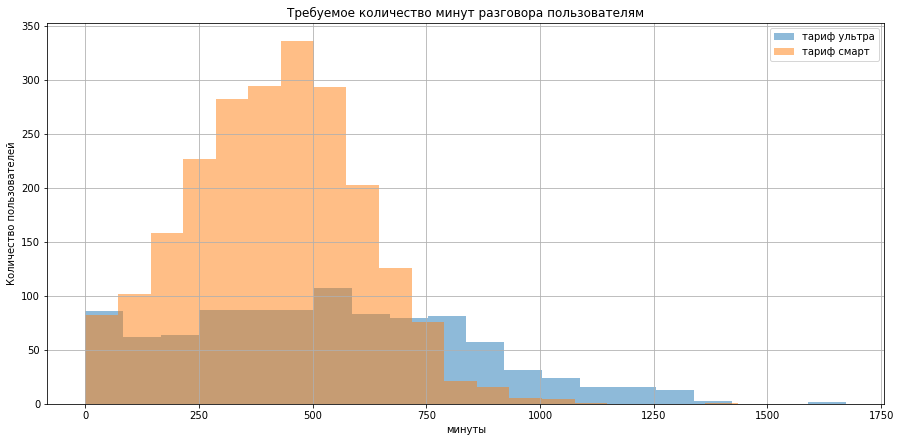

In [55]:
fig = plt.figure(figsize = (15,7))
ax = fig.add_subplot(111)

df_ultra['duration_of_calls'].hist(bins = 20, label = 'тариф ультра', alpha = 0.5)
df_smart['duration_of_calls'].hist(bins = 20, label = 'тариф смарт', alpha = 0.5)

ax.set_title('Требуемое количество минут разговора пользователям')
ax.set_xlabel('минуты')
ax.set_ylabel('Количество пользователей')

ax.legend()
plt.show()

Большая площадь гистограммы тарифа смарт вызвана тем, что пользователей с данным тарифом гораздо больше.   
Солидный процент пользователей тарифа смарт превышает свой 500 минутный лимит.   
Пользователи тарифа ультра свой лемит не превышают. Но и тратят время на звонки они обычно больше. И разброс значений у них выше. Это должно доказать стандартное отклонение

Так же можно выделить, что гистограмма тарифа смарт скошена влево. Среднее значение будет меньше чем медианное значение

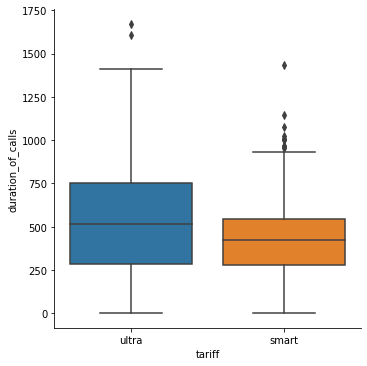

In [56]:
sns.catplot(x='tariff',y='duration_of_calls',kind='box',data=df);

Построив ящик с усами, наши выводы подтверждаются. 
Пользователи тарифа смарт на самом деле меньше пользуются звонками, но взамен они чаще превышают свой лимит. 
У пользоваталей тарифа ультра будет больше стандартное отклонение

In [57]:
df_ultra['duration_of_calls'].mean() # считаю среднее для тарифа ультра

526.0892494929006

In [58]:
df_smart['duration_of_calls'].mean() # считаю среднее для тарифа смарт

417.747533632287

In [59]:
np.var(df_ultra['duration_of_calls']) # считаю дисперсию тарифа ультра

100950.00623331097

In [60]:
np.var(df_smart['duration_of_calls'])   # считаю дисперсию тарифа смарт

36265.12415310985

In [61]:
np.var(df_ultra['duration_of_calls'])**0.5  # считаю стандартное отклонение тарифа ультра

317.72630711559117

In [62]:
np.var(df_smart['duration_of_calls'])**0.5   # считаю стандартное отклонение тарифа смарт

190.4340414765959

**Вывод**   
на тарифе смарт люди стараются не превышать 500 минутные лимит. Возможно этим можно объяснить небольшой скос влево.   
Пакет минут на тарифе ультра мало кто использует свыше 50%. 

### Изучение потраченных смс пользователями

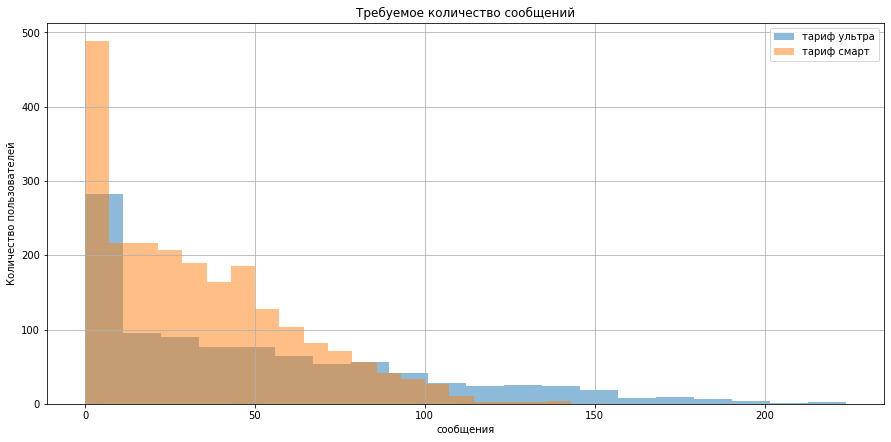

In [63]:
fig = plt.figure(figsize = (15,7))
ax = fig.add_subplot(111)

df_ultra['number_of_messages'].hist(bins = 20, label = 'тариф ультра', alpha = 0.5)
df_smart['number_of_messages'].hist(bins = 20, label = 'тариф смарт', alpha = 0.5)

ax.set_title('Требуемое количество сообщений')
ax.set_xlabel('сообщения')
ax.set_ylabel('Количество пользователей')

ax.legend()
plt.show()

Тут мы наблюдаем что обе гистограммы смещены вправо. 
Думаю это вызвано тем, что пользователи толком не пользуются смс сообщениями и мы не можем получить значения ниже определённого. На данном примере ниже 0

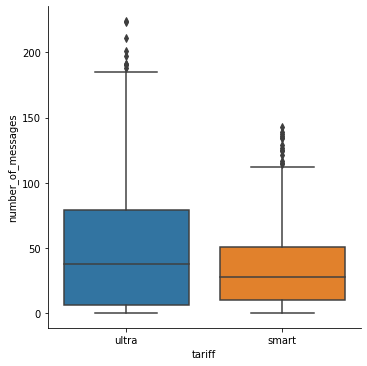

In [64]:
sns.catplot(x='tariff',y='number_of_messages',kind='box',data=df);

Что и требовалось доказать. Пользователи почти не пользуются смс сообщениями. Межквартильный размах почти лежит на 0.

In [65]:
df_ultra['number_of_messages'].mean() # считаю среднее для тарифа ультра

49.31338742393509

In [66]:
df_smart['number_of_messages'].mean() # считаю среднее для тарифа смарт

33.36905829596412

In [67]:
np.var(df_ultra['number_of_messages']) # считаю дисперсию тарифа ультра

2283.0995570851965

In [68]:
np.var(df_smart['number_of_messages']) # считаю дисперсию тарифа смарт

796.5978766916688

In [69]:
np.var(df_ultra['number_of_messages'])**0.5 # считаю стандартное отклонение тарифа ультра

47.781791061922284

In [70]:
np.var(df_smart['number_of_messages'])**0.5 # считаю стандартное отклонение тарифа смарт

28.224065559229217

**Вывод**   
Большая часть пользователей не пользуется смс сообщениям.   
Но все же более 25%+ пользователей тарифа смарт превышают свой лимит 

### Изучение интернет траффика 

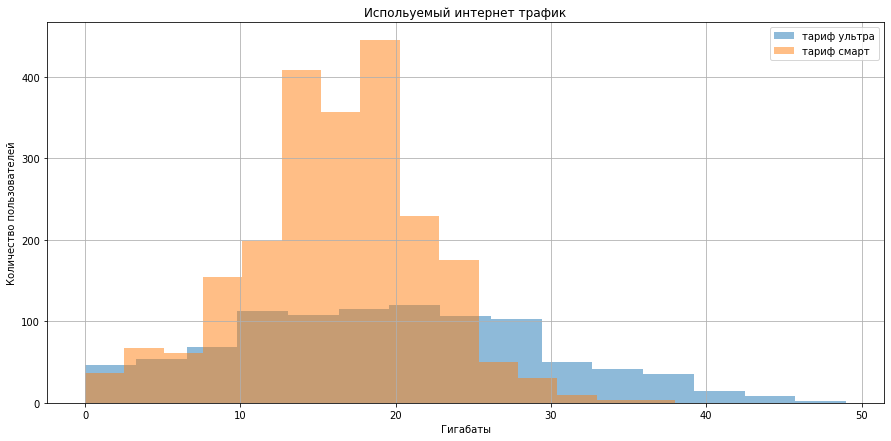

In [71]:
fig = plt.figure(figsize = (15,7))
ax = fig.add_subplot(111)

df_ultra['gb_used'].hist(bins = 15, label = 'тариф ультра', alpha = 0.5)
df_smart['gb_used'].hist(bins = 15, label = 'тариф смарт', alpha = 0.5)

ax.set_title('Испольуемый интернет трафик')
ax.set_xlabel('Гигабаты')
ax.set_ylabel('Количество пользователей')

ax.legend()
plt.show()

С интернетом дела обстоят лучше. Графики гистограмм почти близки к нормальному распределению

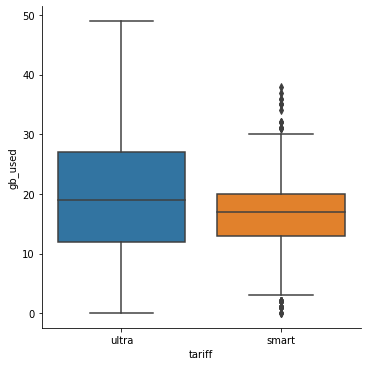

In [72]:
sns.catplot(x='tariff',y='gb_used',kind='box',data=df);

Да, пользователи лучше всего пользуются интернетом. 
Можно даже обратить внимание, что пользователи тарифа смарт, которые не пользуются интернетом уже считаются аномальными значениями. 

In [73]:
df_ultra['gb_used'].mean() # считаю среднее для тарифа ультра

19.474645030425965

In [74]:
df_smart['gb_used'].mean() # считаю среднее для тарифа смарт

16.32152466367713

In [75]:
np.var(df_ultra['gb_used']) # считаю дисперсию тарифа ультра

97.27978308900674

In [76]:
np.var(df_smart['gb_used']) # считаю дисперсию тарифа смарт

33.11859498481772

In [77]:
np.var(df_ultra['gb_used'])**0.5 # считаю стандартное отклонение тарифа ультра

9.863051408616236

In [78]:
np.var(df_smart['gb_used'])**0.5 # считаю стандартное отклонение тарифа смарт

5.754875757548352

**Вывод**  
Более 50% тарифа смарт не хватает тарифного пакета. 
И это первый случай, когда солидной части тарифа ультра тоже не хватает тарифного пакета. Более 25% превышают лимит на интернет

### Вывод

У пользователей тарифа ультра всегда более большое стандартное отклонение. У них большие тарифные пакеты и они могут не ограничивать себя в общении и в смс.
С пользователей тарифа смарт обычно фирма получает более 550рублей, поскольку они часто превышают свои тарифные лимиты 

## Проверка гипотез

### средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

In [79]:
sample_1 = df_ultra['cost']
sample_2 = df_smart['cost']
# Нулевая гипотеза гласит, что выручки пользователей разных тарифов не различаются
# H1 гласит, что выручки на разных тарифах различаются 

alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(sample_1, sample_2, equal_var = False) 

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  1.927011394420941e-250
Отвергаем нулевую гипотезу


In [80]:
sample_1.describe() # информация о тарифе ультра

count     986.00
mean    2,070.03
std       376.02
min     1,950.00
25%     1,950.00
50%     1,950.00
75%     1,950.00
max     4,800.00
Name: cost, dtype: float64

In [81]:
sample_2.describe() # информация о тарифе смарт 

count   2,230.00
mean    1,289.64
std       818.37
min       550.00
25%       550.00
50%     1,021.00
75%     1,750.00
max     6,770.00
Name: cost, dtype: float64

**Вывод**  
Мы можем отклонить нулевую гипотезу  потому-что экспериментальные данные очень маловероятны при условии, что гипотеза верна.


Вероятность допустить ошибку первого рода настолько мала как и гипотетическая вероятность возникновения жизни из случайного сцепления молекул.

Но даже учитывая такой малый шанс, гипотетическая вероятность допустить ошибку первого рода все равно имеется. 


### средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [82]:
sample_1 = df[df['city'] == 'Москва']['cost']
sample_2 = df[df['city'] != 'Москва']['cost']
# нулевая гипотеза гласит, что выручка пользователей из москвы не отличается от выручки пользователей из других регионов
# H1 гласит, что выручки различаются

alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(sample_1, sample_2, equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.5216952110000278
Не получилось отвергнуть нулевую гипотезу


Так же мне захотелось проверить изменяется ли p-value для различных тарифов

In [83]:
sample_1 = df[(df['city'] == 'Москва') & (df['tariff'] == 'ultra')]['cost']
sample_2 = df[(df['city'] != 'Москва') & (df['tariff'] == 'ultra')]['cost']
# нулевая гипотеза гласит, что выручка пользователей тарифа ультра из москвы не отличается от выручки остальных пользователей
# H1 гласит, что выручки различаются

alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(sample_1, sample_2, equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.8499417228125277
Не получилось отвергнуть нулевую гипотезу


In [84]:
sample_1 = df[(df['city'] == 'Москва') & (df['tariff'] == 'smart')]['cost']
sample_2 = df[(df['city'] != 'Москва') & (df['tariff'] == 'smart')]['cost']
# нулевая гипотеза гласит, что выручка пользователей тарифа смарт из москвы не отличается от 
#выручки пользователей из других регионов
# H1 гласит, что выручки различаются

alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(sample_1, sample_2, equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.15741281346674896
Не получилось отвергнуть нулевую гипотезу


**Вывод**  
Даже при таком большом критическом уровне статистической значимости мы не смогли отвергнуть нулевую гипотезу. 
Это не значит, что она верна, просто у нас нет достаточных доказательств предполагать, что она не верна. 

## Общий вывод

Тариф смарт:
1) Пользователи тарифа смарт часто превышают свой 500минутный лимит на звонки. (в 30% случаях)  
2) Большинству пользователей данного тарифа не нужны смс сообщения. перерасход тарифа на смс сообщения крайне редкий. Зафиксировано 308 случаев, когда пользователи тарифа смарт из заднной выборки не отправили ни одного сообщения за месяц   
3) Интернет пользуется большим спросом. медианные значения по интернет трафику выходят за пределы интернет тарифа  

С пользователей тарифа смарт фирма получает более 550рублей. Поскольку им часто приходится превышать доступные пакеты связи
           
               
    
Тариф ультра:
1) Имеется очень большой пакет на звонки. Пользователям доступно 3000 минут разговора. Рекорд по всей выборке 1613. Что составляет чуть больше 50% от величины пакета. Возможо стоит пересмотреть величину пакета на звонки    
2) Так же имеется очень большой пакет смс. Доступно 1000 смс сообщений. P.s. значения в расход в 200 сообщений в месяц уже считаются выбросами и аномально высокими значениями. Большее 80% смс пакета не расходуется пользователями    
3) Интернет пользуется гиганстким спросом. в более 50% случаев пользователи данного тарифа превышают интернет трафик. 

По поводу общих данных. Анализ показал, что 15% пользователей вообще не использовали смс сообщения за заданный период. 
В противовес интернет трафиком пользовались более 99% пользователей. 

Статистика позволила нам подтвердить гипотезу о различии средней выручки пользователей тарифов «Ультра» и «Смарт» (при p-value = 0.05)
У тарифа смарт медианные значения выручки = 1021, std = 818
Тариф ультра. медианные значения выручки = 1950, std = 376


Подтвердить гипотезу о разной выручке пользователей из Москвы и из других городов не получилось.
